<html>
<table width="100%" cellspacing="2" cellpadding="2" border="1">
<tbody>
<tr>
<td valign="center" align="center" width="25%"><img src="../../media/decartes.jpg"
alt="DeCART Icon" width="128" height="171"><br>
</td>
<td valign="center" align="center" width="75%">
<h1 align="center"><font size="+3">DeCART Summer School<br>
for<br>
Biomedical Data Science</font></h1></td>
<td valign="center" align="center" width="25%"><img
src="../../media/U_Health_stacked_png_red.png" alt="Utah Health
Logo" width="128" height="134"><br>
</td>
</tr>
</tbody>
</table>
<br>
</html>


# Working with Textual Data
#### &copy; Brian E. Chapman, Ph.D.


### To get the latest version of this lesson, execute the cell below

In [1]:
%matplotlib inline

In [2]:
import pymysql
import pandas as pd
import getpass
from textblob import TextBlob

In [3]:
conn = pymysql.connect(host="mysql",
                       port=3306,user="jovyan",
                       passwd=getpass.getpass("Enter MySQL passwd for jovyan"),db='mimic2')
cursor = conn.cursor()

Enter MySQL passwd for jovyan········


### Use Pandas and SQL to create a dataframe with the following:
* subject_id
* hospital admission id
* text of the radiology report
* Limit the number of reports to 10000

In [4]:
rad_data = \
pd.read_sql("""SELECT noteevents.subject_id, 
                      noteevents.hadm_id,
                      noteevents.text 
               FROM noteevents
               WHERE noteevents.category = 'RADIOLOGY_REPORT' LIMIT 10000""",conn)
rad_data.head(5)

,subject_id,hadm_id,text
0,56,28766,\n\n\n DATE: [**2644-1-17**] 10:53 AM\n ...
1,56,28766,\n\n\n DATE: [**2644-1-17**] 10:53 AM\n ...
2,56,28766,\n\n\n DATE: [**2644-1-17**] 10:43 AM\n ...
3,56,28766,\n\n\n DATE: [**2644-1-17**] 6:37 AM\n ...
4,56,28766,\n\n\n DATE: [**2644-1-19**] 12:09 PM\n ...


In [5]:
rad_data.shape

(10000, 3)

In [6]:
print(rad_data["text"][0])




     DATE: [**2644-1-17**] 10:53 AM
     MR HEAD W & W/O CONTRAST; MR CONTRAST GADOLIN                   Clip # [**Clip Number (Radiology) 12569**]
     Reason: R ICB and HX brain mets - eval - also with DWI for CVA Do MR
      Contrast: MAGNEVIST Amt: 15
     ______________________________________________________________________________
     UNDERLYING MEDICAL CONDITION:
      [**Age over 90 **] year old woman with lung CA- mets to brain                                   
     REASON FOR THIS EXAMINATION:
      R ICB and HX brain mets - eval - also with DWI for CVA Do MRI both with and 
      without contast please
     ______________________________________________________________________________
                                     FINAL REPORT
     EXAMINATION:  MRI of the brain with and without gadolinium.
     
     INDICATION:  [**Age over 90 **] year old woman with lung cancer and right intracranial bleed
     and history of brain metastases.  Please evaluate for acute infar

## Section Splitting

<img src="http://medicine.utah.edu/dbmi/images/faculty/Chapman,Wendy_240x360.jpg"
alt="Wendy Chapman" width="128">

Clinical reports are often divided into sections. Physicians are taught to write their reports in the SOAP format: subjective information, objective information, assessment, and plan, and sections often reflect this process. Information each setion may be formatted differently. For example, subjective information is often narrative, telling a story of the patient's description of their past medical history and their current issues. The objective section may be much more telegraphic with shortened descriptions of measurements like blood pressure and heart rate, such as "120/80 88". You may need different NLP techniques to accurately extract information out of different sections. Sentence splitting, for example, may be different in subjective versus objective sections. Radiology reports are not in the SOAP format, but section identification can still be very important, because in these reports the radiologist describes what she sees on the radiographic image then sometimes summarizes her impression of what the observations may represent, such as "the infiltrate could be consistent with pneumonia." For some tasks, you may only be interested in the impression, which has more weight than the reasoning that occurs in the Findings section.

## Exercise

Write a function that returns the impression section of a report. The function will take two arguments:

1. The text to search for the impression section is the first positional argument.
1. A list of phrases to use to identify the impression section.

Not every report will have a section labeled "IMPRESSION". You can consider "INTERPRETATION" and "CONCLUSIONS" as synonyms for "IMPRESSION"

If you cannot identify the impresison section (or equivalent), return an empty string.

#### Hints

* Use a for loop  to iterate across
* Use the find method of a string to identify where in the string the impression section occurs
* Use slicing to grab the impression section


In [10]:

def find_impression(report, section=None):
    if section==None:
        section=["IMPRESSION:", "INTERPRETATION:", "CONCLUSIONS:"]
    for s in section:
        index=report.find(s)
        if s !=-1:
            return report[index:]
    return ""

print (find_impression(rad_data["text"][100]))


IMPRESSION: 1) Stable appearance of small pleural effusion and retrocardiac
     opacity. 2) Kink in right sided subclavian central venous line in the region
     where it likely enters the skin.




## Exercise 

Use ``apply()`` to create a new column in the ``rad_data`` named "IMPRESSIONS" with the string identified with ``find_impression()``.

In [11]:
rad_data.head()
rad_data["IMPRESSION"] = rad_data.apply(lambda row: find_impression(row["text"]), axis=1)
rad_data.head()

,subject_id,hadm_id,text,IMPRESSION
0,56,28766,\n\n\n DATE: [**2644-1-17**] 10:53 AM\n ...,\n
1,56,28766,\n\n\n DATE: [**2644-1-17**] 10:53 AM\n ...,\n
2,56,28766,\n\n\n DATE: [**2644-1-17**] 10:43 AM\n ...,IMPRESSION: Stable appearance of right pariet...
3,56,28766,\n\n\n DATE: [**2644-1-17**] 6:37 AM\n ...,IMPRESSION:\n \n Cardiomegaly and mild...
4,56,28766,\n\n\n DATE: [**2644-1-19**] 12:09 PM\n ...,IMPRESSION:\n \n Marked improvement in...


## How else might we need to break up a report?

* How would I break a report into sentences?
* How would I break a report into words?

## Group Exercise

### Create a single string with all the reports

#### Hints, etc.
* Use List Comprehension
* Use string joins
* Iterate over the rows of the data frame
* Use TextBlob to get words

In [12]:
rad_data.head()

,subject_id,hadm_id,text,IMPRESSION
0,56,28766,\n\n\n DATE: [**2644-1-17**] 10:53 AM\n ...,\n
1,56,28766,\n\n\n DATE: [**2644-1-17**] 10:53 AM\n ...,\n
2,56,28766,\n\n\n DATE: [**2644-1-17**] 10:43 AM\n ...,IMPRESSION: Stable appearance of right pariet...
3,56,28766,\n\n\n DATE: [**2644-1-17**] 6:37 AM\n ...,IMPRESSION:\n \n Cardiomegaly and mild...
4,56,28766,\n\n\n DATE: [**2644-1-19**] 12:09 PM\n ...,IMPRESSION:\n \n Marked improvement in...


In [13]:
imps = [row["IMPRESSION"] for _, row in rad_data[:5].iterrows()]

In [14]:
imps = []
for _, row in rad_data[:5].iterrows():
    imps.append(row["IMPRESSION"])

In [15]:
imps[2]

'IMPRESSION:  Stable appearance of right parietal lobe and left thalamic\n     hemorrhages, which are concerning for hemorrhagic metastasis in this patient\n     with known metastatic lung carcinoma to the brain.\n     \n     \n\n'

In [16]:
all_text = ""
for impression in imps:
    all_text = all_text + " " +impression

In [17]:
len(all_text)

1373

In [18]:
all_text = " ".join(imps)

In [19]:
all_text = " ".join([row["IMPRESSION"] for _, row in rad_data.iterrows()])

In [20]:
len(all_text)

3128140

(-0.5, 11999.5, 11999.5, -0.5)

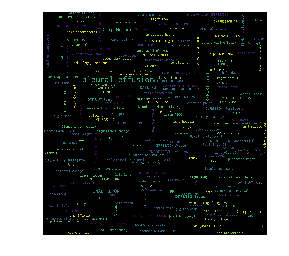

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
plt.imshow(WordCloud(min_font_size=6, scale=20, height=600, width=600).generate(all_text))
plt.axis("off")

In [ ]:
plt.imshow(WordCloud(width=2400, height=2400).generate(all_text), interpolation=bilinear)